# The Impact of Savings Rates on External Debt

In [2890]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
import haversine as hs   
from haversine import Unit
import os
from skimpy import skim
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS


warnings.filterwarnings("ignore")

## Acquiring the Data

In [2891]:
data = pd.read_csv("7735b571-235b-410c-bed4-288671561d93_Data.csv")
data = data.drop(columns=["Country Code", "Series Code"])
data.columns = data.columns.str.replace(r"\[YR\d{4}\]", "", regex=True)
data

,Country Name,Series Name,1996,1997,1998,1999,2000,2001,2002,2003,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,"GDP per capita, PPP (constant 2021 internation...",..,..,..,..,1617.82647494969,1454.11078195559,1774.30874287341,1815.92819979586,...,3017.94254424696,2967.692067153,2958.7853992308,2952.99891598909,2902.39211285546,2927.2451435353,2769.68574507111,2144.16657002819,1981.71016810561,1992.42439419795
1,Afghanistan,GDP (constant 2015 US$),..,..,..,..,6206547590.07403,5621147630.73068,7228795918.92525,7867263256.28817,...,18860496494.0404,19134221644.7325,19566715174.1633,20084646751.4954,20323499020.3639,21118473702.3471,20621957125.2077,16345202562.5485,15325233810.1388,15740683549.2312
2,Afghanistan,"Inflation, consumer prices (annual %)",..,..,..,..,..,..,..,..,...,4.67399603536305,-0.66170916471352,4.38389195513893,4.97595150553892,0.626149149168983,2.30237251516819,..,..,..,..
3,Afghanistan,"Inflation, GDP deflator (annual %)",..,..,..,..,..,-11.7745360319214,6.12552202910163,11.655238221181,...,0.56694454253261,2.44756300147404,-2.19752646733461,2.40365618765746,2.07134857783487,6.52147984832531,6.9629462552564,2.83899625081041,9.40623933931322,2.9616535410169
4,Afghanistan,Lending interest rate (%),..,..,..,..,..,..,..,..,...,15,15,15,14.8366666666667,..,..,..,..,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5428,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2892]:
data = data.melt(id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')
data = data.pivot_table(
    index=['Country Name', 'Year'],
    columns='Series Name',
    values='Value',
    aggfunc='first'
)
data.replace('..', np.nan, inplace=True)
data = data.apply(pd.to_numeric)
data = data.reset_index()
data

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)","Central government debt, total (% of GDP)",Current account balance (% of GDP),Deposit interest rate (%),Domestic credit provided by financial sector (% of GDP),Domestic credit to private sector (% of GDP),...,Gross savings (% of GNI),"Inflation, GDP deflator (annual %)","Inflation, consumer prices (annual %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Real effective exchange rate index (2010 = 100),Real interest rate (%),Trade (% of GDP)
0,Afghanistan,1996,105.223953,4.644441,100.579512,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,47.500000,-2.417310,17763266.0,NaN,NaN,NaN
1,Afghanistan,1997,106.412389,4.674985,101.737404,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,47.500000,NaN,18452091.0,NaN,NaN,NaN
2,Afghanistan,1998,107.593616,4.700057,102.893559,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,47.500000,-2.427355,19159996.0,NaN,NaN,NaN
3,Afghanistan,1999,108.686031,4.722150,103.963881,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,46.619531,NaN,19887785.0,NaN,NaN,NaN
4,Afghanistan,2000,109.586048,4.740774,104.845274,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,47.357575,-2.438969,20130327.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6071,Zimbabwe,2019,85.447906,6.554177,78.893729,NaN,3.579179,2.975000,NaN,5.237706,...,17.049070,225.394648,255.304991,16.181667,NaN,-0.943303,15271368.0,NaN,-64.295151,55.795961
6072,Zimbabwe,2020,84.384381,6.604042,77.780339,NaN,4.080178,4.518333,NaN,5.415074,...,15.405863,604.945864,557.201817,33.008333,51.329013,-1.052743,15526888.0,NaN,-81.132121,47.313365
6073,Zimbabwe,2021,83.384953,6.598137,76.786816,NaN,1.278300,8.059167,NaN,6.988543,...,17.638194,113.294981,98.546105,45.476667,88.552447,-0.954443,15797210.0,NaN,-31.795551,50.847128
6074,Zimbabwe,2022,82.547605,6.586732,75.960874,NaN,0.930064,34.720000,NaN,8.759576,...,12.846740,266.987152,104.705171,131.813333,374.954363,-0.894974,16069056.0,NaN,-36.833393,64.763608


In [2893]:
data["Year"] = pd.to_numeric(data["Year"])
print(data.dtypes)

Series Name
Country Name                                                        object
Year                                                                 int64
Age dependency ratio (% of working-age population)                 float64
Age dependency ratio, old (% of working-age population)            float64
Age dependency ratio, young (% of working-age population)          float64
Central government debt, total (% of GDP)                          float64
Current account balance (% of GDP)                                 float64
Deposit interest rate (%)                                          float64
Domestic credit provided by financial sector (% of GDP)            float64
Domestic credit to private sector (% of GDP)                       float64
External debt stocks (% of GNI)                                    float64
Foreign direct investment, net inflows (% of GDP)                  float64
Foreign direct investment, net outflows (% of GDP)                 float64
GDP (constant

### Cleaning the data

In [2894]:
missing_by_year = data.groupby("Year").apply(lambda x: x.isnull().sum())
missing_by_year

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)","Central government debt, total (% of GDP)",Current account balance (% of GDP),Deposit interest rate (%),Domestic credit provided by financial sector (% of GDP),Domestic credit to private sector (% of GDP),...,Gross savings (% of GNI),"Inflation, GDP deflator (annual %)","Inflation, consumer prices (annual %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Real effective exchange rate index (2010 = 100),Real interest rate (%),Trade (% of GDP)
Year,,,,,,,,,,,,,,,,,,,,,
1996,0,0,0,0,0,168,72,112,201,101,...,94,20,59,120,17,31,0,123,120,53
1997,0,0,0,0,0,167,70,108,200,99,...,93,20,59,115,15,217,0,122,115,52
1998,0,0,0,0,0,157,70,106,200,98,...,94,18,59,111,15,31,0,122,111,52
1999,0,0,0,0,0,156,69,105,200,99,...,92,18,57,106,14,217,0,122,106,52
2000,0,0,0,0,0,163,69,104,200,97,...,89,18,54,106,13,30,0,122,106,50
2001,0,0,0,0,0,168,67,100,191,76,...,88,17,49,102,14,217,0,122,102,50
2002,0,0,0,0,0,165,61,97,190,73,...,82,17,47,101,14,30,0,122,101,44
2003,0,0,0,0,0,168,59,95,190,73,...,80,13,44,100,15,20,0,122,100,43
2004,0,0,0,0,0,171,57,89,188,68,...,80,13,43,94,15,16,0,122,95,43


In [2895]:
data = data.drop(columns=["Central government debt, total (% of GDP)", 
                          "Domestic credit provided by financial sector (% of GDP)",
                          "Real effective exchange rate index (2010 = 100)",
                          ])
data = data[~data["Year"].isin([2023])]

In [2896]:
missing_by_year = data.groupby("Year").apply(lambda x: x.isnull().sum())
missing_by_year

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),Deposit interest rate (%),Domestic credit to private sector (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",...,Gross savings (% of GDP),Gross savings (% of GNI),"Inflation, GDP deflator (annual %)","Inflation, consumer prices (annual %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Real interest rate (%),Trade (% of GDP)
Year,,,,,,,,,,,,,,,,,,,,,
1996,0,0,0,0,0,72,112,101,111,56,...,94,94,20,59,120,17,31,0,120,53
1997,0,0,0,0,0,70,108,99,110,54,...,93,93,20,59,115,15,217,0,115,52
1998,0,0,0,0,0,70,106,98,110,54,...,94,94,18,59,111,15,31,0,111,52
1999,0,0,0,0,0,69,105,99,109,55,...,92,92,18,57,106,14,217,0,106,52
2000,0,0,0,0,0,69,104,97,108,55,...,89,89,18,54,106,13,30,0,106,50
2001,0,0,0,0,0,67,100,76,107,50,...,88,88,17,49,102,14,217,0,102,50
2002,0,0,0,0,0,61,97,73,106,46,...,82,82,17,47,101,14,30,0,101,44
2003,0,0,0,0,0,59,95,73,106,44,...,80,80,13,44,100,15,20,0,100,43
2004,0,0,0,0,0,57,89,68,106,44,...,80,80,13,43,94,15,16,0,95,43


In [2897]:
missing_by_country = data.groupby("Country Name")[[
    "External debt stocks (% of GNI)", 
    "Gross savings (% of GDP)",
]].apply(lambda x: x.isnull().sum())
missing_by_country["Total Missing"] = missing_by_country.sum(axis=1)
missing_by_country = missing_by_country.sort_values(by="Total Missing", ascending=False)

missing_by_country.head(50)

Series Name,External debt stocks (% of GNI),Gross savings (% of GDP),Total Missing
Country Name,,,
"Micronesia, Fed. Sts.",27,27,54
Greenland,27,27,54
St. Kitts and Nevis,27,27,54
Cayman Islands,27,27,54
Cuba,27,27,54
Sint Maarten (Dutch part),27,27,54
Equatorial Guinea,27,27,54
Monaco,27,27,54
British Virgin Islands,27,27,54


In [2898]:
threshold = 2
countries_to_drop = missing_by_country[missing_by_country["Total Missing"] >= threshold].index.tolist()
data = data[~data["Country Name"].isin(countries_to_drop)]
print(f"Dropped {len(countries_to_drop)} countries due to excessive missing values.")
print("Dropped Countries:", countries_to_drop)

Dropped 155 countries due to excessive missing values.
Dropped Countries: ['Micronesia, Fed. Sts.', 'Greenland', 'St. Kitts and Nevis', 'Cayman Islands', 'Cuba', 'Sint Maarten (Dutch part)', 'Equatorial Guinea', 'Monaco', 'British Virgin Islands', 'Trinidad and Tobago', 'French Polynesia', 'Turks and Caicos Islands', 'Tuvalu', 'United Arab Emirates', 'Channel Islands', 'Gibraltar', 'St. Martin (French part)', 'Barbados', 'Liechtenstein', 'Nauru', 'Puerto Rico', 'American Samoa', 'Isle of Man', "Korea, Dem. People's Rep.", 'Northern Mariana Islands', 'Andorra', 'Virgin Islands (U.S.)', 'Guam', 'Antigua and Barbuda', 'South Sudan', 'San Marino', 'Curacao', 'Somalia', 'Bermuda', 'Qatar', 'Suriname', 'Faroe Islands', 'Nigeria', 'New Caledonia', 'Afghanistan', 'Kiribati', 'Marshall Islands', 'Ireland', 'Austria', 'Palau', 'Venezuela, RB', 'Macao SAR, China', 'Belgium', 'Eritrea', 'Brunei Darussalam', 'Sao Tome and Principe', 'Liberia', 'New Zealand', 'Croatia', 'Luxembourg', 'Hong Kong SAR,

In [2899]:
data

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),Deposit interest rate (%),Domestic credit to private sector (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",...,Gross savings (% of GDP),Gross savings (% of GNI),"Inflation, GDP deflator (annual %)","Inflation, consumer prices (annual %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Real interest rate (%),Trade (% of GDP)
28,Albania,1996,60.160695,10.313422,49.847273,-3.353501,16.783333,NaN,15.039617,2.815941,...,16.132509,15.779008,38.172058,12.725478,23.958333,104.498917,-0.336625,3168033.0,-10.286975,44.895445
29,Albania,1997,59.892707,10.614191,49.278516,-12.053611,27.275833,NaN,22.369474,2.103153,...,5.572394,5.450916,11.239644,33.180274,32.708333,148.932917,NaN,3148281.0,19.299494,45.425556
30,Albania,1998,59.502668,10.927039,48.575630,-2.555809,22.560000,NaN,23.778678,1.767896,...,17.337436,16.831540,6.730860,20.642859,NaN,150.633333,-0.544004,3128530.0,NaN,48.137535
31,Albania,1999,59.064263,11.266992,47.797272,-4.837924,12.945833,NaN,23.516922,1.282641,...,14.899579,14.558438,2.102850,0.389438,21.615000,137.690583,NaN,3108778.0,19.110289,51.011030
32,Albania,2000,58.597729,11.626308,46.971421,-4.490921,8.302500,NaN,31.298437,4.108776,...,25.891349,25.135540,5.647471,0.050018,22.102500,143.709417,-0.539990,3089027.0,15.575412,63.454073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,Viet Nam,2018,46.123352,10.201776,35.921576,1.902364,4.738250,105.275985,38.269613,4.998283,...,30.931698,32.594546,3.626647,3.539628,7.371875,22602.050000,0.033083,96237319.0,3.614155,164.663937
5931,Viet Nam,2019,46.605432,10.629231,35.976201,3.918244,4.975000,108.031901,38.573354,4.821075,...,31.333031,32.990405,2.423227,2.795824,7.707500,23050.241667,0.039987,97173776.0,5.159253,164.704215
5932,Viet Nam,2020,46.964136,11.121135,35.843001,4.344869,4.120208,115.525350,39.023491,4.558362,...,33.007326,34.481362,1.467478,3.220934,7.647500,23208.368333,-0.038989,98079191.0,6.090643,163.245863
5933,Viet Nam,2021,47.239298,11.610854,35.628444,-1.262843,3.375000,124.282899,40.258254,4.273146,...,32.596364,34.353942,2.880768,1.834716,7.811000,23159.782593,-0.117782,98935098.0,4.792180,186.675833


In [2900]:
missing_by_year = data.groupby("Year").apply(lambda x: x.isnull().sum())
missing_by_year

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),Deposit interest rate (%),Domestic credit to private sector (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",...,Gross savings (% of GDP),Gross savings (% of GNI),"Inflation, GDP deflator (annual %)","Inflation, consumer prices (annual %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Real interest rate (%),Trade (% of GDP)
Year,,,,,,,,,,,,,,,,,,,,,
1996,0,0,0,0,0,1,23,23,0,2,...,1,1,0,4,26,1,0,0,26,0
1997,0,0,0,0,0,0,20,22,0,1,...,0,0,0,4,23,1,62,0,23,0
1998,0,0,0,0,0,0,19,22,0,1,...,0,0,0,4,21,1,0,0,21,0
1999,0,0,0,0,0,0,19,23,0,0,...,0,0,0,4,20,1,62,0,20,0
2000,0,0,0,0,0,0,19,22,0,1,...,0,0,0,3,20,0,0,0,20,0
2001,0,0,0,0,0,0,18,17,0,0,...,0,0,0,3,20,0,62,0,20,0
2002,0,0,0,0,0,0,19,16,0,1,...,0,0,0,3,22,0,0,0,22,0
2003,0,0,0,0,0,0,19,16,0,1,...,0,0,0,3,21,0,0,0,21,0
2004,0,0,0,0,0,0,17,15,0,1,...,0,0,0,3,19,0,0,0,19,0


In [2901]:
data = data.drop(columns=["Deposit interest rate (%)", 
                          "Domestic credit to private sector (% of GDP)",
                          "Lending interest rate (%)",
                          "Real interest rate (%)",
                          'GNI (constant 2015 US$)',
                          'Foreign direct investment, net outflows (% of GDP)',
                          "Inflation, consumer prices (annual %)",
                          ])
missing_by_year = data.groupby("Year").apply(lambda x: x.isnull().sum())
missing_by_year

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),"GDP per capita, PPP (constant 2021 international $)",Gross savings (% of GDP),Gross savings (% of GNI),"Inflation, GDP deflator (annual %)","Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Trade (% of GDP)
Year,,,,,,,,,,,,,,,,,
1996,0,0,0,0,0,1,0,2,0,0,1,1,0,1,0,0,0
1997,0,0,0,0,0,0,0,1,0,0,0,0,0,1,62,0,0
1998,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1999,0,0,0,0,0,0,0,0,0,0,0,0,0,1,62,0,0
2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,0,0
2002,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2003,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2004,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Deriving New Variables

In [2902]:
data["External debt stocks (% of GDP)"] = (data["External debt stocks (% of GNI)"] / data["Gross savings (% of GNI)"]) * data["Gross savings (% of GDP)"]
data

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),"GDP per capita, PPP (constant 2021 international $)",Gross savings (% of GDP),Gross savings (% of GNI),"Inflation, GDP deflator (annual %)","Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Trade (% of GDP),External debt stocks (% of GDP)
28,Albania,1996,60.160695,10.313422,49.847273,-3.353501,15.039617,2.815941,5.175147e+09,5418.148325,16.132509,15.779008,38.172058,104.498917,-0.336625,3168033.0,44.895445,15.376552
29,Albania,1997,59.892707,10.614191,49.278516,-12.053611,22.369474,2.103153,4.610021e+09,4856.768289,5.572394,5.450916,11.239644,148.932917,NaN,3148281.0,45.425556,22.867999
30,Albania,1998,59.502668,10.927039,48.575630,-2.555809,23.778678,1.767896,5.017060e+09,5318.961888,17.337436,16.831540,6.730860,150.633333,-0.544004,3128530.0,48.137535,24.493381
31,Albania,1999,59.064263,11.266992,47.797272,-4.837924,23.516922,1.282641,5.663799e+09,6042.769898,14.899579,14.558438,2.102850,137.690583,NaN,3108778.0,51.011030,24.067983
32,Albania,2000,58.597729,11.626308,46.971421,-4.490921,31.298437,4.108776,6.057219e+09,6503.834597,25.891349,25.135540,5.647471,143.709417,-0.539990,3089027.0,63.454073,32.239560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,Viet Nam,2018,46.123352,10.201776,35.921576,1.902364,38.269613,4.998283,2.933586e+11,10936.893786,30.931698,32.594546,3.626647,22602.050000,0.033083,96237319.0,164.663937,36.317245
5931,Viet Nam,2019,46.605432,10.629231,35.976201,3.918244,38.573354,4.821075,3.149476e+11,11628.613915,31.333031,32.990405,2.423227,23050.241667,0.039987,97173776.0,164.704215,36.635504
5932,Viet Nam,2020,46.964136,11.121135,35.843001,4.344869,39.023491,4.558362,3.239722e+11,11851.396569,33.007326,34.481362,1.467478,23208.368333,-0.038989,98079191.0,163.245863,37.355284
5933,Viet Nam,2021,47.239298,11.610854,35.628444,-1.262843,40.258254,4.273146,3.322456e+11,12048.901994,32.596364,34.353942,2.880768,23159.782593,-0.117782,98935098.0,186.675833,38.198605


In [2903]:
data["External_debt"] = (data["External debt stocks (% of GDP)"] * data["GDP (constant 2015 US$)"])
data["Gross_savings"] = (data["Gross savings (% of GDP)"] * data["GDP (constant 2015 US$)"])
data["Trade"] = (data["Trade (% of GDP)"] * data["GDP (constant 2015 US$)"])
data["Current_balance"] = (data["Current account balance (% of GDP)"] * data["GDP (constant 2015 US$)"])
data["Foreign_investment"] = (data["Foreign direct investment, net inflows (% of GDP)"] * data["GDP (constant 2015 US$)"])
data             

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),"GDP per capita, PPP (constant 2021 international $)",...,"Official exchange rate (LCU per US$, period average)",Political Stability and Absence of Violence/Terrorism: Estimate,"Population, total",Trade (% of GDP),External debt stocks (% of GDP),External_debt,Gross_savings,Trade,Current_balance,Foreign_investment
28,Albania,1996,60.160695,10.313422,49.847273,-3.353501,15.039617,2.815941,5.175147e+09,5418.148325,...,104.498917,-0.336625,3168033.0,44.895445,15.376552,7.957591e+10,8.348810e+10,2.323405e+11,-1.735486e+10,1.457291e+10
29,Albania,1997,59.892707,10.614191,49.278516,-12.053611,22.369474,2.103153,4.610021e+09,4856.768289,...,148.932917,NaN,3148281.0,45.425556,22.867999,1.054220e+11,2.568886e+10,2.094128e+11,-5.556741e+10,9.695580e+09
30,Albania,1998,59.502668,10.927039,48.575630,-2.555809,23.778678,1.767896,5.017060e+09,5318.961888,...,150.633333,-0.544004,3128530.0,48.137535,24.493381,1.228848e+11,8.698295e+10,2.415089e+11,-1.282265e+10,8.869639e+09
31,Albania,1999,59.064263,11.266992,47.797272,-4.837924,23.516922,1.282641,5.663799e+09,6042.769898,...,137.690583,NaN,3108778.0,51.011030,24.067983,1.363162e+11,8.438822e+10,2.889162e+11,-2.740103e+10,7.264623e+09
32,Albania,2000,58.597729,11.626308,46.971421,-4.490921,31.298437,4.108776,6.057219e+09,6503.834597,...,143.709417,-0.539990,3089027.0,63.454073,32.239560,1.952821e+11,1.568296e+11,3.843552e+11,-2.720249e+10,2.488776e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,Viet Nam,2018,46.123352,10.201776,35.921576,1.902364,38.269613,4.998283,2.933586e+11,10936.893786,...,22602.050000,0.033083,96237319.0,164.663937,36.317245,1.065398e+13,9.074080e+12,4.830558e+13,5.580748e+11,1.466289e+12
5931,Viet Nam,2019,46.605432,10.629231,35.976201,3.918244,38.573354,4.821075,3.149476e+11,11628.613915,...,23050.241667,0.039987,97173776.0,164.704215,36.635504,1.153827e+13,9.868264e+12,5.187320e+13,1.234042e+12,1.518386e+12
5932,Viet Nam,2020,46.964136,11.121135,35.843001,4.344869,39.023491,4.558362,3.239722e+11,11851.396569,...,23208.368333,-0.038989,98079191.0,163.245863,37.355284,1.210207e+13,1.069346e+13,5.288712e+13,1.407617e+12,1.476783e+12
5933,Viet Nam,2021,47.239298,11.610854,35.628444,-1.262843,40.258254,4.273146,3.322456e+11,12048.901994,...,23159.782593,-0.117782,98935098.0,186.675833,38.198605,1.269132e+13,1.083000e+13,6.202222e+13,-4.195739e+11,1.419734e+12


In [2904]:
# Calculate the logarithm of the specified columns
data["lndebt"] = np.log(data["External_debt"])
data["lnsavings"] = np.log(data["Gross_savings"])
data["lnTrade"] = np.log(data["Trade"])
data["lnbalance"] = np.log(data["Current_balance"])
data["lnFor"] = np.log(data["Foreign_investment"])
data["lnPop"] = np.log(data["Population, total"])
data["lnGDP"] = np.log(data["GDP per capita, PPP (constant 2021 international $)"])
# Display the updated dataframe
data.head()

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),"GDP per capita, PPP (constant 2021 international $)",...,Trade,Current_balance,Foreign_investment,lndebt,lnsavings,lnTrade,lnbalance,lnFor,lnPop,lnGDP
28,Albania,1996,60.160695,10.313422,49.847273,-3.353501,15.039617,2.815941,5.175147e+09,5418.148325,...,2.323405e+11,-1.735486e+10,1.457291e+10,25.099977,25.147970,26.171470,NaN,23.402430,14.968621,8.597509
29,Albania,1997,59.892707,10.614191,49.278516,-12.053611,22.369474,2.103153,4.610021e+09,4856.768289,...,2.094128e+11,-5.556741e+10,9.695580e+09,25.381237,23.969323,26.067573,NaN,22.994936,14.962367,8.488129
30,Albania,1998,59.502668,10.927039,48.575630,-2.555809,23.778678,1.767896,5.017060e+09,5318.961888,...,2.415089e+11,-1.282265e+10,8.869639e+09,25.534513,25.188978,26.210172,NaN,22.905900,14.956074,8.579033
31,Albania,1999,59.064263,11.266992,47.797272,-4.837924,23.516922,1.282641,5.663799e+09,6042.769898,...,2.889162e+11,-2.740103e+10,7.264623e+09,25.638243,25.158694,26.389403,NaN,22.706282,14.949740,8.706618
32,Albania,2000,58.597729,11.626308,46.971421,-4.490921,31.298437,4.108776,6.057219e+09,6503.834597,...,3.843552e+11,-2.720249e+10,2.488776e+10,25.997711,25.778426,26.674833,NaN,23.937642,14.943367,8.780147


In [2905]:
data.describe()

Series Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),"GDP per capita, PPP (constant 2021 international $)",Gross savings (% of GDP),...,Trade,Current_balance,Foreign_investment,lndebt,lnsavings,lnTrade,lnbalance,lnFor,lnPop,lnGDP
count,1674.000000,1674.000000,1674.000000,1674.000000,1672.000000,1674.000000,1666.000000,1.674000e+03,1674.000000,1671.000000,...,1.674000e+03,1.672000e+03,1.666000e+03,1671.000000,1652.000000,1674.000000,325.000000,1615.000000,1674.000000,1674.000000
mean,2009.000000,65.511759,8.964278,56.547481,-3.903988,49.812821,3.509709,2.759824e+11,9303.225146,20.562078,...,1.323579e+13,8.628553e+10,6.887972e+11,27.991337,27.247881,28.432833,26.000427,-inf,16.531975,8.846446
std,7.791208,17.797946,4.412299,20.881756,6.451366,33.911957,4.242099,1.169364e+12,6674.936726,9.589102,...,4.885168e+13,3.410336e+12,2.713503e+12,1.838281,2.124681,1.795975,2.337524,NaN,1.716358,0.813951
min,1996.000000,37.241083,3.852565,19.831956,-43.771235,3.895006,-37.172653,4.650951e+08,829.387160,-19.643625,...,3.108066e+10,-8.531316e+12,-1.089223e+12,22.865677,18.802196,24.159852,19.694410,-inf,12.048898,6.720687
25%,2002.000000,51.270060,5.907004,40.197697,-6.702628,26.681009,1.231764,9.692542e+09,3576.287048,14.391782,...,6.661042e+11,-2.279959e+11,2.117350e+10,26.748478,25.925204,27.224712,24.713592,23.913540,15.570636,8.182080
50%,2009.000000,60.906885,7.464318,53.500923,-3.472876,40.079825,2.581217,2.773616e+10,7870.630143,18.885963,...,1.930009e+12,-6.879872e+10,7.879579e+10,27.880093,26.974831,28.288546,26.063061,25.185444,16.402383,8.970891
75%,2016.000000,79.480017,10.043916,73.283870,-0.826604,63.572951,4.557433,1.232806e+11,13451.995057,26.441243,...,7.772648e+12,-1.116130e+10,2.987512e+11,29.229020,28.766177,29.681632,27.644239,26.464978,17.620223,9.506882
max,2022.000000,111.209538,26.524933,105.874708,33.679364,301.213848,55.072877,1.631900e+13,33506.261489,51.787587,...,6.258577e+14,5.713328e+13,3.069257e+13,33.121325,34.247937,34.070144,31.676408,31.055042,21.077735,10.419488


In [2906]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [2907]:
missing_by_country = data.groupby("Country Name")[[
    "lndebt", 
    "lnsavings",
]].apply(lambda x: x.isnull().sum())
missing_by_country["Total Missing"] = missing_by_country.sum(axis=1)
missing_by_country = missing_by_country.sort_values(by="Total Missing", ascending=False)

missing_by_country.head(50)

Series Name,lndebt,lnsavings,Total Missing
Country Name,,,
Guinea,0,6,6
Solomon Islands,0,5,5
Georgia,1,2,3
Burundi,0,2,2
Senegal,1,1,2
Sierra Leone,0,2,2
Jordan,1,1,2
Kyrgyz Republic,0,1,1
Sudan,0,1,1


In [2908]:
threshold = 5
countries_to_drop = missing_by_country[missing_by_country["Total Missing"] >= threshold].index.tolist()
data = data[~data["Country Name"].isin(countries_to_drop)]
print(f"Dropped {len(countries_to_drop)} countries due to excessive missing values.")
print("Dropped Countries:", countries_to_drop)

Dropped 2 countries due to excessive missing values.
Dropped Countries: ['Guinea', 'Solomon Islands']


In [2909]:
data = data.dropna(subset=['lndebt', 'lnsavings'])

In [2910]:
data

Series Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),"GDP per capita, PPP (constant 2021 international $)",...,Trade,Current_balance,Foreign_investment,lndebt,lnsavings,lnTrade,lnbalance,lnFor,lnPop,lnGDP
28,Albania,1996,60.160695,10.313422,49.847273,-3.353501,15.039617,2.815941,5.175147e+09,5418.148325,...,2.323405e+11,-1.735486e+10,1.457291e+10,25.099977,25.147970,26.171470,NaN,23.402430,14.968621,8.597509
29,Albania,1997,59.892707,10.614191,49.278516,-12.053611,22.369474,2.103153,4.610021e+09,4856.768289,...,2.094128e+11,-5.556741e+10,9.695580e+09,25.381237,23.969323,26.067573,NaN,22.994936,14.962367,8.488129
30,Albania,1998,59.502668,10.927039,48.575630,-2.555809,23.778678,1.767896,5.017060e+09,5318.961888,...,2.415089e+11,-1.282265e+10,8.869639e+09,25.534513,25.188978,26.210172,NaN,22.905900,14.956074,8.579033
31,Albania,1999,59.064263,11.266992,47.797272,-4.837924,23.516922,1.282641,5.663799e+09,6042.769898,...,2.889162e+11,-2.740103e+10,7.264623e+09,25.638243,25.158694,26.389403,NaN,22.706282,14.949740,8.706618
32,Albania,2000,58.597729,11.626308,46.971421,-4.490921,31.298437,4.108776,6.057219e+09,6503.834597,...,3.843552e+11,-2.720249e+10,2.488776e+10,25.997711,25.778426,26.674833,NaN,23.937642,14.943367,8.780147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,Viet Nam,2018,46.123352,10.201776,35.921576,1.902364,38.269613,4.998283,2.933586e+11,10936.893786,...,4.830558e+13,5.580748e+11,1.466289e+12,29.996954,29.836443,31.508568,27.047759,28.013756,18.382328,9.299897
5931,Viet Nam,2019,46.605432,10.629231,35.976201,3.918244,38.573354,4.821075,3.149476e+11,11628.613915,...,5.187320e+13,1.234042e+12,1.518386e+12,30.076690,29.920345,31.579823,27.841316,28.048669,18.392011,9.361224
5932,Viet Nam,2020,46.964136,11.121135,35.843001,4.344869,39.023491,4.558362,3.239722e+11,11851.396569,...,5.288712e+13,1.407617e+12,1.476783e+12,30.124398,30.000653,31.599181,27.972919,28.020887,18.401286,9.380201
5933,Viet Nam,2021,47.239298,11.610854,35.628444,-1.262843,40.258254,4.273146,3.322456e+11,12048.901994,...,6.202222e+13,-4.195739e+11,1.419734e+12,30.171939,30.013341,31.758514,NaN,27.981490,18.409975,9.396729


### Summary Statistics

In [2911]:
data[["Gross savings (% of GDP)", "GDP per capita, PPP (constant 2021 international $)", 
      "External debt stocks (% of GDP)", "GDP (constant 2015 US$)", "External_debt",
          "Gross_savings", "Trade", "lndebt", "lnsavings", "lnGDP", "lnTrade"]].describe().T.map('{:,.2f}'.format)

,count,mean,std,min,25%,50%,75%,max
Series Name,,,,,,,,
Gross savings (% of GDP),"1,609.00",20.92,9.07,0.30,14.65,19.12,26.58,51.79
"GDP per capita, PPP (constant 2021 international $)","1,609.00","9,564.79","6,674.34",829.39,"3,871.45","8,455.18","13,659.64","33,506.26"
External debt stocks (% of GDP),"1,609.00",48.51,32.00,3.68,26.49,39.10,62.84,259.01
GDP (constant 2015 US$),"1,609.00","286,888,225,439.15","1,191,477,298,775.67","465,095,149.81","10,574,444,193.43","31,084,433,518.16","139,658,819,217.11","16,318,995,784,492.70"
External_debt,"1,609.00","7,290,248,506,565.16","18,978,740,935,266.94","8,519,953,069.74","446,345,630,826.99","1,400,668,120,827.64","5,249,300,598,391.60","242,330,923,744,602.72"
Gross_savings,"1,609.00","9,539,768,288,183.73","53,351,060,922,218.55","146,450,241.24","190,103,495,742.36","553,989,890,543.72","3,188,007,773,951.84","747,635,610,700,333.88"
Trade,"1,609.00","13,753,257,003,580.11","49,759,787,698,450.56","41,698,184,477.00","737,394,536,422.47","2,081,151,988,842.24","8,077,343,759,042.47","625,857,674,452,494.00"
lndebt,"1,609.00",28.09,1.78,22.87,26.82,27.97,29.29,33.12
lnsavings,"1,609.00",27.32,2.09,18.80,25.97,27.04,28.79,34.25


Text(0, 0.5, 'Frequency')

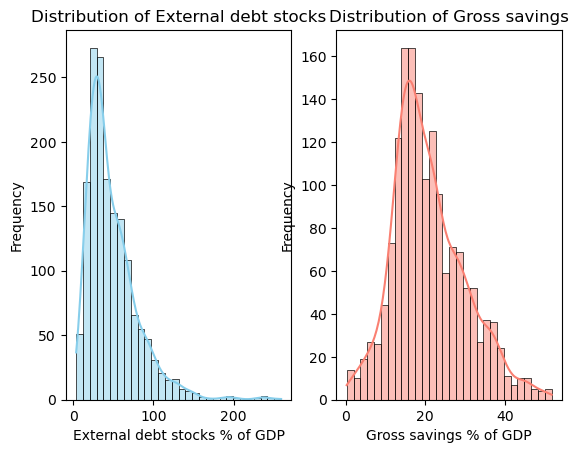

In [2912]:
plt.subplot(1, 2, 1)
sns.histplot(data["External debt stocks (% of GDP)"], bins=30, kde=True, color='skyblue')
plt.title('Distribution of External debt stocks')
plt.xlabel('External debt stocks % of GDP')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data["Gross savings (% of GDP)"], bins=30, kde=True, color='salmon')
plt.title('Distribution of Gross savings')
plt.xlabel('Gross savings % of GDP')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

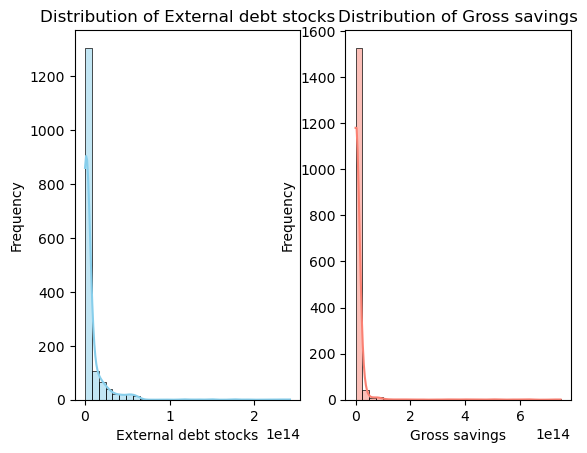

In [2913]:
plt.subplot(1, 2, 1)
sns.histplot(data["External_debt"], bins=30, kde=True, color='skyblue')
plt.title('Distribution of External debt stocks')
plt.xlabel('External debt stocks')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data["Gross_savings"], bins=30, kde=True, color='salmon')
plt.title('Distribution of Gross savings')
plt.xlabel('Gross savings')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

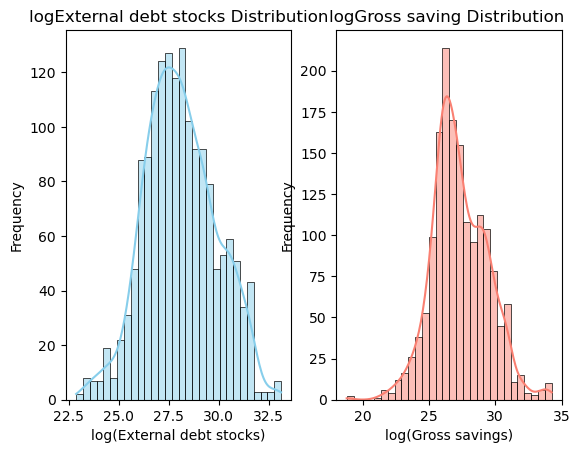

In [2914]:
plt.subplot(1, 2, 1)
sns.histplot(data["lndebt"], bins=30, kde=True, color='skyblue')
plt.title('logExternal debt stocks Distribution')
plt.xlabel('log(External debt stocks)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data["lnsavings"], bins=30, kde=True, color='salmon')
plt.title('logGross saving Distribution ')
plt.xlabel('log(Gross savings)')
plt.ylabel('Frequency')

In [2915]:
total_external_debt = data["External_debt"].sum()
total_gross_savings = data["Gross_savings"].sum()

print("Total External Debt:", total_external_debt)
print("Total Gross Savings:", total_gross_savings)

Total External Debt: 1.1730009847063342e+16
Total Gross Savings: 1.5349487175687628e+16


In [2916]:
data = data.reset_index()

In [2917]:
missing_counts = data.isnull().sum()
print(missing_counts)

Series Name
index                                                                 0
Country Name                                                          0
Year                                                                  0
Age dependency ratio (% of working-age population)                    0
Age dependency ratio, old (% of working-age population)               0
Age dependency ratio, young (% of working-age population)             0
Current account balance (% of GDP)                                    0
External debt stocks (% of GNI)                                       0
Foreign direct investment, net inflows (% of GDP)                     6
GDP (constant 2015 US$)                                               0
GDP per capita, PPP (constant 2021 international $)                   0
Gross savings (% of GDP)                                              0
Gross savings (% of GNI)                                              0
Inflation, GDP deflator (annual %)                  

## Cross sectional for 2006 year

In [2918]:
data2006 = data[data['Year'] == 2006]
data2006

Series Name,index,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),...,Trade,Current_balance,Foreign_investment,lndebt,lnsavings,lnTrade,lnbalance,lnFor,lnPop,lnGDP
10,38,Albania,2006,52.413235,14.266368,38.146868,-7.541576,27.484385,3.654851,8.532852e+09,...,6.337101e+11,-6.435115e+10,3.118631e+10,26.209857,26.236860,27.174857,NaN,24.163245,14.911635,9.154551
37,206,Argentina,2006,58.000353,15.870683,42.129670,2.794496,52.877976,2.381069,4.703256e+11,...,1.901690e+13,1.314323e+12,1.119877e+12,30.811186,29.940887,30.576349,27.904343,27.744240,17.494898,10.121709
63,234,Armenia,2006,46.486223,16.558129,29.928094,-2.395373,31.988189,7.307315,7.978594e+09,...,4.869347e+11,-1.911171e+10,5.830209e+10,26.311617,26.151504,26.911396,NaN,24.788904,14.955617,9.161700
90,346,Azerbaijan,2006,44.870312,9.542602,35.327709,17.670467,15.270045,21.380140,2.970581e+10,...,3.126905e+12,5.249155e+11,6.351143e+11,26.712992,27.923147,28.771065,26.986503,27.177071,15.953757,9.485893
117,430,Bangladesh,2006,64.524040,6.254832,58.269208,1.665925,26.572916,0.635864,1.141117e+11,...,4.349016e+12,1.901015e+11,7.255950e+10,28.795210,29.025493,29.100971,25.970824,25.007673,18.801894,8.133713
144,486,Belarus,2006,42.772560,21.112698,21.659861,-3.754948,17.808988,0.966130,4.122141e+10,...,5.123619e+12,-1.547843e+11,3.982525e+10,27.318817,27.828587,29.264882,NaN,24.407767,16.077786,9.817378
171,542,Belize,2006,70.921527,6.791666,64.129860,-1.595323,72.260895,6.839616,1.852241e+09,...,1.831113e+11,-2.954923e+09,1.266862e+10,25.537935,24.455480,25.933360,NaN,23.262394,12.570292,9.464991
198,570,Benin,2006,90.464070,5.824865,84.639205,-3.087787,17.918194,-0.175765,7.829312e+09,...,3.114085e+11,-2.417525e+10,-1.376116e+09,25.662649,25.304054,26.464372,NaN,NaN,15.978057,7.883152
225,654,Bolivia,2006,70.431832,9.160321,61.271511,11.504455,56.589721,2.451688,2.115174e+10,...,1.576605e+12,2.433392e+11,5.185746e+10,27.775511,27.055231,28.086295,26.217722,24.671765,16.069083,8.821494
252,710,Botswana,2006,62.639765,5.560332,57.079433,19.664776,3.895006,4.908815,1.099404e+10,...,9.522203e+11,2.161953e+11,5.396769e+10,24.422727,26.842602,27.582062,26.099448,24.711651,14.443861,9.634013


In [2919]:
data2006.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 10 to 1592
Data columns (total 31 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   index                                                            60 non-null     int64  
 1   Country Name                                                     60 non-null     object 
 2   Year                                                             60 non-null     int64  
 3   Age dependency ratio (% of working-age population)               60 non-null     float64
 4   Age dependency ratio, old (% of working-age population)          60 non-null     float64
 5   Age dependency ratio, young (% of working-age population)        60 non-null     float64
 6   Current account balance (% of GDP)                               60 non-null     float64
 7   External debt stocks (% of GNI)                 

In [2920]:
data2006.describe()

Series Name,index,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),"GDP per capita, PPP (constant 2021 international $)",...,Trade,Current_balance,Foreign_investment,lndebt,lnsavings,lnTrade,lnbalance,lnFor,lnPop,lnGDP
count,60.000000,60.0,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,60.000000,...,6.000000e+01,6.000000e+01,6.000000e+01,60.000000,60.000000,60.000000,18.000000,58.000000,60.000000,60.000000
mean,2830.533333,2006.0,65.313703,8.684006,56.629696,-2.176806,38.725165,4.733661,2.180924e+11,8815.830643,...,1.268849e+13,6.570474e+11,7.602897e+11,27.745180,27.364931,28.503708,26.506781,25.382025,16.550664,8.826217
std,1785.632827,0.0,17.757922,4.230530,20.732608,6.944593,24.325493,4.894710,6.860774e+11,5849.154532,...,4.246655e+13,5.460170e+12,2.923510e+12,1.799113,2.027344,1.753817,1.806422,2.248292,1.695287,0.779483
min,38.000000,2006.0,38.209441,4.001174,20.442873,-16.448894,3.895006,-0.175765,5.951548e+08,954.190854,...,5.329103e+10,-3.143555e+12,-1.376116e+09,23.429959,23.054256,24.699034,23.755651,15.555248,12.282677,6.860864
25%,1179.000000,2006.0,50.612957,5.809675,40.652304,-5.674928,22.102343,1.953972,9.057622e+09,3942.515511,...,7.094080e+11,-1.416253e+11,3.170543e+10,26.468265,25.867965,27.287641,25.763169,24.264520,15.537276,8.279497
50%,2796.000000,2006.0,62.061415,7.442853,54.541450,-2.598008,30.771209,3.619692,2.717536e+10,8224.121765,...,1.981086e+12,-4.163719e+10,7.257982e+10,27.572515,27.047891,28.314376,26.367221,25.022793,16.441155,9.014587
75%,4210.000000,2006.0,76.733267,9.582662,71.038375,1.093975,48.548668,6.431097,1.169091e+11,12884.327262,...,7.526290e+12,3.780726e+10,5.148077e+11,29.051821,28.889027,29.648922,27.508631,27.003912,17.526177,9.463767
max,5918.000000,2006.0,109.306445,22.243409,104.734596,19.664776,108.489326,23.537291,4.982880e+12,24877.249392,...,3.212921e+14,4.197661e+13,2.246582e+13,31.710256,33.113643,33.403372,31.368134,30.743016,20.994071,10.121709


Text(0, 0.5, 'Frequency')

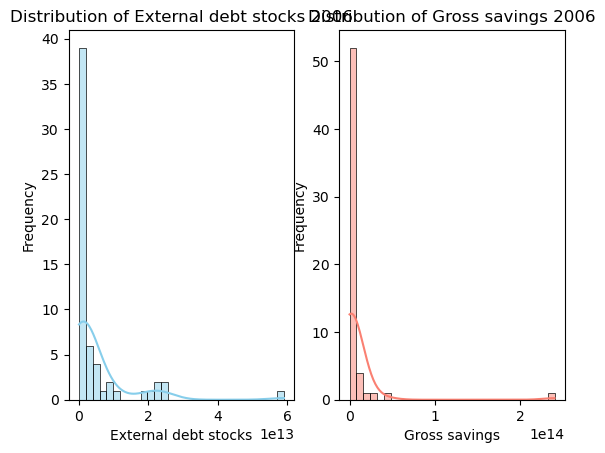

In [2921]:
plt.subplot(1, 2, 1)
sns.histplot(data2006["External_debt"], bins=30, kde=True, color='skyblue')
plt.title('Distribution of External debt stocks 2006')
plt.xlabel('External debt stocks')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data2006["Gross_savings"], bins=30, kde=True, color='salmon')
plt.title('Distribution of Gross savings 2006')
plt.xlabel('Gross savings')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

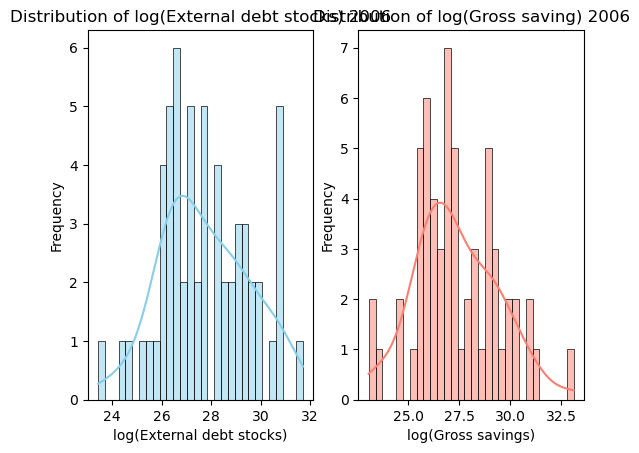

In [2922]:
plt.subplot(1, 2, 1)
sns.histplot(data2006["lndebt"], bins=30, kde=True, color='skyblue')
plt.title('Distribution of log(External debt stocks) 2006')
plt.xlabel('log(External debt stocks)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data2006["lnsavings"], bins=30, kde=True, color='salmon')
plt.title('Distribution of log(Gross saving) 2006')
plt.xlabel('log(Gross savings)')
plt.ylabel('Frequency')

In [2923]:
reg1 = smf.ols(
    formula="Q('External debt stocks (% of GDP)') ~ Q('Gross savings (% of GDP)')", 
    data=data2006
).fit()
print(reg1.summary())

                                     OLS Regression Results                                     
Dep. Variable:     Q('External debt stocks (% of GDP)')   R-squared:                       0.019
Model:                                              OLS   Adj. R-squared:                  0.002
Method:                                   Least Squares   F-statistic:                     1.128
Date:                                  Sat, 01 Mar 2025   Prob (F-statistic):              0.293
Time:                                          11:31:49   Log-Likelihood:                -273.45
No. Observations:                                    60   AIC:                             550.9
Df Residuals:                                        58   BIC:                             555.1
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                              

In [2924]:
reg2 = smf.ols(
    formula="Q('External_debt') ~ Q('Gross_savings') + Q('GDP (constant 2015 US$)') +Q('Inflation, GDP deflator (annual %)') + Trade", 
    data=data2006
).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:     Q('External_debt')   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     159.9
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           1.36e-29
Time:                        11:31:49   Log-Likelihood:                -1802.9
No. Observations:                  60   AIC:                             3616.
Df Residuals:                      55   BIC:                             3626.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [2925]:
reg3 = smf.ols(
    formula="Q('lndebt') ~ Q('lnsavings')", 
    data=data2006
).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:            Q('lndebt')   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     314.4
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           4.29e-25
Time:                        11:31:49   Log-Likelihood:                -64.080
No. Observations:                  60   AIC:                             132.2
Df Residuals:                      58   BIC:                             136.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.4317      1.262      4.

In [2926]:
reg5 = smf.ols(
    formula="Q('lndebt') ~ Q('lnsavings') + Q('lnGDP') + Q('Inflation, GDP deflator (annual %)') + lnTrade", 
    data=data2006
).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:     Q('External_debt')   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     159.9
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           1.36e-29
Time:                        11:31:49   Log-Likelihood:                -1802.9
No. Observations:                  60   AIC:                             3616.
Df Residuals:                      55   BIC:                             3626.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [2927]:
table1 = Stargazer([reg1, reg2, reg3, reg5])
table1

## Fixed effects model

In [2928]:
datai = data.reset_index()
year_dummies = pd.get_dummies(data["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datai = pd.concat([data, year_dummies], axis=1)
datai = datai.set_index(["Country Name", "Year"])
datai

index  Age dependency ratio (% of working-age population)  \
Country Name Year                                                              
Albania      1996     28                                          60.160695    
             1997     29                                          59.892707    
             1998     30                                          59.502668    
             1999     31                                          59.064263    
             2000     32                                          58.597729    
...                  ...                                                ...    
Viet Nam     2018   5930                                          46.123352    
             2019   5931                                          46.605432    
             2020   5932                                          46.964136    
             2021   5933                                          47.239298    
             2022   5934                                          47.416365    

                   Age dependency ratio, old (% of working-age population)  \
Country Name Year                                                            
Albania      1996                                          10.313422         
             1997                                          10.614191         
             1998                                          10.927039         
             1999                                          11.266992         
             2000                                          11.626308         
...                                                              ...         
Viet Nam     2018                                          10.201776         
             2019                                          10.629231         
             2020                                          11.121135         
             2021                                          11.610854         
             2022                                          12.132436         

                   Age dependency ratio, young (% of working-age population)  \
Country Name Year                                                              
Albania      1996                                          49.847273           
             1997                                          49.278516           
             1998                                          48.575630           
             1999                                          47.797272           
             2000                                          46.971421           
...                                                              ...           
Viet Nam     2018                                          35.921576           
             2019                                          35.976201           
             2020                                          35.843001           
             2021                                          35.628444           
             2022                                          35.283928           

                   Current account balance (% of GDP)  \
Country Name Year                                       
Albania      1996                           -3.353501   
             1997                          -12.053611   
             1998                           -2.555809   
             1999                           -4.837924   
             2000                           -4.490921   
...                                               ...   
Viet Nam     2018                            1.902364   
             2019                            3.918244   
             2020                            4.344869   
             2021                           -1.262843   
             2022                            0.341681   

                   External debt stocks (% of GNI)  \
Country Name Year                                    
Albania      1996                        15.039617   
             1997 

In [2929]:
reg6 = PanelOLS.from_formula(
    f"lndebt ~ lnsavings + lnGDP + Q('Inflation, GDP deflator (annual %)') + lnTrade + {year_dummy_vars} + EntityEffects",
    datai
).fit(cov_type="clustered", cluster_entity=True)

print(reg6.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lndebt   R-squared:                        0.5520
Estimator:                   PanelOLS   R-squared (Between):              0.5553
No. Observations:                1609   R-squared (Within):               0.5520
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.5553
Time:                        11:31:50   Log-likelihood                   -588.30
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      62.378
Entities:                          60   P-value                           0.0000
Avg Obs:                       26.817   Distribution:                 F(30,1519)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):             22.137
                            

In [2930]:
reg7 = PanelOLS.from_formula(
    f"Q('External debt stocks (% of GDP)') ~ Q('Gross savings (% of GDP)') + lnGDP + Q('Inflation, GDP deflator (annual %)') + Q('Trade (% of GDP)') + {year_dummy_vars} + EntityEffects",
    datai
).fit(cov_type="clustered", cluster_entity=True)

print(reg7.summary)

                                   PanelOLS Estimation Summary                                    
Dep. Variable:     Q('External debt stocks (% of GDP)')   R-squared:                        0.2321
Estimator:                                     PanelOLS   R-squared (Between):             -29.201
No. Observations:                                  1609   R-squared (Within):               0.2321
Date:                                  Sat, Mar 01 2025   R-squared (Overall):             -24.728
Time:                                          11:31:51   Log-likelihood                   -7130.7
Cov. Estimator:                               Clustered                                           
                                                          F-statistic:                      15.302
Entities:                                            60   P-value                           0.0000
Avg Obs:                                         26.817   Distribution:                 F(30,1519)
Min Obs:  

In [2931]:
reg20 = PanelOLS.from_formula(
    f"lndebt ~ lnsavings + lnGDP + {year_dummy_vars} + EntityEffects",
    datai
).fit(cov_type="clustered", cluster_entity=True)

print(reg20.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lndebt   R-squared:                        0.5507
Estimator:                   PanelOLS   R-squared (Between):              0.5334
No. Observations:                1609   R-squared (Within):               0.5507
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.5334
Time:                        11:31:53   Log-likelihood                   -590.54
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      66.584
Entities:                          60   P-value                           0.0000
Avg Obs:                       26.817   Distribution:                 F(28,1521)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):             22.772
                            

In [2932]:
reg21 = PanelOLS.from_formula(
    f"lndebt ~ lnsavings + {year_dummy_vars} + EntityEffects",
    datai
).fit(cov_type="clustered", cluster_entity=True)

print(reg21.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lndebt   R-squared:                        0.4116
Estimator:                   PanelOLS   R-squared (Between):              0.1278
No. Observations:                1609   R-squared (Within):               0.4116
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.1279
Time:                        11:31:54   Log-likelihood                   -807.55
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      39.432
Entities:                          60   P-value                           0.0000
Avg Obs:                       26.817   Distribution:                 F(27,1522)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):             23.107
                            

In [2959]:
table2 = Stargazer([reg21, reg20, reg6, reg7])
table2

In [2934]:
reg14 = PanelOLS.from_formula(
    f"External_debt ~ Gross_savings + Q('GDP (constant 2015 US$)') + Trade + EntityEffects",
    datai
).fit(cov_type="clustered", cluster_entity=True)

print(reg14.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:          External_debt   R-squared:                        0.8652
Estimator:                   PanelOLS   R-squared (Between):              0.9346
No. Observations:                1609   R-squared (Within):               0.8654
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.9147
Time:                        11:31:54   Log-likelihood                -4.886e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4964.7
Entities:                          60   P-value                           0.0000
Avg Obs:                       26.817   Distribution:                  F(2,1547)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):             73.001
                            

In [2935]:
reg15 = PanelOLS.from_formula(
    "External_debt ~ Gross_savings + Q('GDP (constant 2015 US$)') + Trade + TimeEffects + EntityEffects",
    datai
).fit(cov_type="clustered", cluster_entity=True)
print(reg15.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:          External_debt   R-squared:                        0.8632
Estimator:                   PanelOLS   R-squared (Between):              0.9331
No. Observations:                1609   R-squared (Within):               0.8653
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.9136
Time:                        11:31:54   Log-likelihood                -4.881e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4798.7
Entities:                          60   P-value                           0.0000
Avg Obs:                       26.817   Distribution:                  F(2,1521)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):             70.273
                            

In [2936]:
table4 = Stargazer([reg14, reg15])
table4

## First differences model

In [2937]:
data = data.sort_values(by=['Country Name', 'Year'])
data['d_lndebt'] = data.groupby('Country Name')['lndebt'].diff()
data['d_lnsavings'] = data.groupby('Country Name')['lnsavings'].diff()
data['d_lnGDP'] = data.groupby('Country Name')['lnGDP'].diff()
data['d_inflation'] = data.groupby('Country Name')['Inflation, GDP deflator (annual %)'].diff()
data['d_trade'] = data.groupby('Country Name')['lnTrade'].diff()
data["d_lnsavings_L1"] = data.groupby("Country Name")["d_lnsavings"].shift(1)  # 1-year lag
data["d_lnsavings_L2"] = data.groupby("Country Name")["d_lnsavings"].shift(2)  # 2-year lag
data

Series Name,index,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)",Current account balance (% of GDP),External debt stocks (% of GNI),"Foreign direct investment, net inflows (% of GDP)",GDP (constant 2015 US$),...,lnFor,lnPop,lnGDP,d_lndebt,d_lnsavings,d_lnGDP,d_inflation,d_trade,d_lnsavings_L1,d_lnsavings_L2
0,28,Albania,1996,60.160695,10.313422,49.847273,-3.353501,15.039617,2.815941,5.175147e+09,...,23.402430,14.968621,8.597509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,Albania,1997,59.892707,10.614191,49.278516,-12.053611,22.369474,2.103153,4.610021e+09,...,22.994936,14.962367,8.488129,0.281260,-1.178647,-0.109381,-26.932414,-0.103897,NaN,NaN
2,30,Albania,1998,59.502668,10.927039,48.575630,-2.555809,23.778678,1.767896,5.017060e+09,...,22.905900,14.956074,8.579033,0.153276,1.219655,0.090905,-4.508785,0.142599,-1.178647,NaN
3,31,Albania,1999,59.064263,11.266992,47.797272,-4.837924,23.516922,1.282641,5.663799e+09,...,22.706282,14.949740,8.706618,0.103730,-0.030284,0.127584,-4.628010,0.179230,1.219655,-1.178647
4,32,Albania,2000,58.597729,11.626308,46.971421,-4.490921,31.298437,4.108776,6.057219e+09,...,23.937642,14.943367,8.780147,0.359468,0.619732,0.073529,3.544621,0.285430,-0.030284,1.219655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,5930,Viet Nam,2018,46.123352,10.201776,35.921576,1.902364,38.269613,4.998283,2.933586e+11,...,28.013756,18.382328,9.299897,-0.000777,0.141428,0.060916,-0.736273,0.094621,0.080616,0.078783
1605,5931,Viet Nam,2019,46.605432,10.629231,35.976201,3.918244,38.573354,4.821075,3.149476e+11,...,28.048669,18.392011,9.361224,0.079736,0.083902,0.061327,-1.203420,0.071255,0.141428,0.080616
1606,5932,Viet Nam,2020,46.964136,11.121135,35.843001,4.344869,39.023491,4.558362,3.239722e+11,...,28.020887,18.401286,9.380201,0.047708,0.080308,0.018977,-0.955749,0.019357,0.083902,0.141428
1607,5933,Viet Nam,2021,47.239298,11.610854,35.628444,-1.262843,40.258254,4.273146,3.322456e+11,...,27.981490,18.409975,9.396729,0.047541,0.012688,0.016528,1.413290,0.159333,0.080308,0.083902


In [2938]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
datadrop = data.dropna(subset=['d_lndebt', 'd_lnsavings'])
X = datadrop[['d_lnsavings', 'd_lnGDP']]
X = sm.add_constant(X)  
y = datadrop['d_lndebt']


reg8 = sm.OLS(y, X).fit()

# Print results
print(reg8.summary())

                            OLS Regression Results                            
Dep. Variable:               d_lndebt   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     9.797
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           5.92e-05
Time:                        11:31:54   Log-Likelihood:                 511.70
No. Observations:                1549   AIC:                            -1017.
Df Residuals:                    1546   BIC:                            -1001.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0516      0.005     10.106      

In [2939]:

datadrop = datadrop.reset_index()
year_dummies = pd.get_dummies(datadrop["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datadrop = pd.concat([datadrop, year_dummies], axis=1)
datadrop = datadrop.set_index(["Country Name", "Year"])
year_dummies = [col for col in datadrop.columns if "Year_" in col]
X = datadrop[['d_lnsavings', 'd_lnGDP', 'd_trade', 'd_inflation'] + year_dummies]
y = datadrop['d_lndebt']
reg9 = PanelOLS(y, X).fit(cov_type="clustered", cluster_entity=True)
print(reg9.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               d_lndebt   R-squared:                        0.2464
Estimator:                   PanelOLS   R-squared (Between):              0.5758
No. Observations:                1549   R-squared (Within):               0.2143
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.2464
Time:                        11:31:55   Log-likelihood                    678.93
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      17.137
Entities:                          60   P-value                           0.0000
Avg Obs:                       25.817   Distribution:                 F(29,1520)
Min Obs:                       24.000                                           
Max Obs:                       26.000   F-statistic (robust):             25.745
                            

In [2940]:
datadrop = data.dropna(subset=['d_lnsavings_L1', "d_lndebt"])
reg10 = smf.ols(
    formula="d_lndebt ~ d_lnsavings + d_lnsavings_L1", 
    data=datadrop
).fit()

# Print summary of the regression
print(reg10.summary())

                            OLS Regression Results                            
Dep. Variable:               d_lndebt   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.662
Date:                Sat, 01 Mar 2025   Prob (F-statistic):            0.00959
Time:                        11:31:55   Log-Likelihood:                 477.91
No. Observations:                1489   AIC:                            -949.8
Df Residuals:                    1486   BIC:                            -933.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0433      0.005      9.

In [2941]:
datadrop = datadrop.reset_index()
year_dummies = pd.get_dummies(datadrop["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datadrop = pd.concat([datadrop, year_dummies], axis=1)
datadrop = datadrop.set_index(["Country Name", "Year"])
year_dummies = [col for col in datadrop.columns if "Year_" in col] 
X = datadrop[['d_lnsavings', 'd_lnsavings_L1', 'd_lnGDP', 'd_trade', 'd_inflation'] + year_dummies]  
y = datadrop['d_lndebt'] 
reg11 = PanelOLS(y, X).fit(cov_type="clustered", cluster_entity=True)
print(reg11.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               d_lndebt   R-squared:                        0.2429
Estimator:                   PanelOLS   R-squared (Between):              0.5718
No. Observations:                1489   R-squared (Within):               0.2122
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.2429
Time:                        11:31:56   Log-likelihood                    641.72
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.151
Entities:                          60   P-value                           0.0000
Avg Obs:                       24.817   Distribution:                 F(29,1460)
Min Obs:                       23.000                                           
Max Obs:                       25.000   F-statistic (robust):             24.508
                            

In [2942]:
datadrop = data.dropna(subset=['d_lnsavings_L2', "d_lndebt"])
reg12 = smf.ols(
    formula="d_lndebt ~ d_lnsavings + d_lnsavings_L1 + d_lnsavings_L2", 
    data=datadrop
).fit()

# Print summary of the regression
print(reg12.summary())

                            OLS Regression Results                            
Dep. Variable:               d_lndebt   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.878
Date:                Sat, 01 Mar 2025   Prob (F-statistic):             0.0349
Time:                        11:31:56   Log-Likelihood:                 465.28
No. Observations:                1429   AIC:                            -922.6
Df Residuals:                    1425   BIC:                            -901.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0427      0.005      8.

In [2943]:
datadrop = datadrop.reset_index()
year_dummies = pd.get_dummies(datadrop["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datadrop = pd.concat([datadrop, year_dummies], axis=1)
datadrop = datadrop.set_index(["Country Name", "Year"])
year_dummies = [col for col in datadrop.columns if "Year_" in col] 
X = datadrop[['d_lnsavings', 'd_lnsavings_L1', 'd_lnsavings_L2', 'd_lnGDP', 'd_trade', 'd_inflation'] + year_dummies]  
y = datadrop['d_lndebt'] 
reg13 = PanelOLS(y, X).fit(cov_type="clustered", cluster_entity=True)
print(reg13.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               d_lndebt   R-squared:                        0.2315
Estimator:                   PanelOLS   R-squared (Between):              0.5672
No. Observations:                1429   R-squared (Within):               0.2013
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.2315
Time:                        11:31:57   Log-likelihood                    615.62
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      14.546
Entities:                          60   P-value                           0.0000
Avg Obs:                       23.817   Distribution:                 F(29,1400)
Min Obs:                       22.000                                           
Max Obs:                       24.000   F-statistic (robust):             21.183
                            

In [2944]:
table3 = Stargazer([reg8, reg9, reg10, reg11, reg12, reg13])
table3

In [2945]:
datadrop = data.dropna(subset=['External_debt', 'Gross_savings'])
year_dummies = pd.get_dummies(datadrop["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datadrop = pd.concat([datadrop, year_dummies], axis=1)
datadrop = datadrop.set_index(["Country Name", "Year"])
year_dummies = [col for col in datadrop.columns if "Year_" in col]
datadrop

index  Age dependency ratio (% of working-age population)  \
Country Name Year                                                              
Albania      1996     28                                          60.160695    
             1997     29                                          59.892707    
             1998     30                                          59.502668    
             1999     31                                          59.064263    
             2000     32                                          58.597729    
...                  ...                                                ...    
Viet Nam     2018   5930                                          46.123352    
             2019   5931                                          46.605432    
             2020   5932                                          46.964136    
             2021   5933                                          47.239298    
             2022   5934                                          47.416365    

                   Age dependency ratio, old (% of working-age population)  \
Country Name Year                                                            
Albania      1996                                          10.313422         
             1997                                          10.614191         
             1998                                          10.927039         
             1999                                          11.266992         
             2000                                          11.626308         
...                                                              ...         
Viet Nam     2018                                          10.201776         
             2019                                          10.629231         
             2020                                          11.121135         
             2021                                          11.610854         
             2022                                          12.132436         

                   Age dependency ratio, young (% of working-age population)  \
Country Name Year                                                              
Albania      1996                                          49.847273           
             1997                                          49.278516           
             1998                                          48.575630           
             1999                                          47.797272           
             2000                                          46.971421           
...                                                              ...           
Viet Nam     2018                                          35.921576           
             2019                                          35.976201           
             2020                                          35.843001           
             2021                                          35.628444           
             2022                                          35.283928           

                   Current account balance (% of GDP)  \
Country Name Year                                       
Albania      1996                           -3.353501   
             1997                          -12.053611   
             1998                           -2.555809   
             1999                           -4.837924   
             2000                           -4.490921   
...                                               ...   
Viet Nam     2018                            1.902364   
             2019                            3.918244   
             2020                            4.344869   
             2021                           -1.262843   
             2022                            0.341681   

                   External debt stocks (% of GNI)  \
Country Name Year                                    
Albania      1996                        15.039617   
             1997 

## Heterogeneity
### dividing by GDP and GDP per capita

In [2946]:
data_2019 = data[data['Year'] == 2019].copy()
median_gdp_pc = data_2019["GDP per capita, PPP (constant 2021 international $)"].median()
data_2019["Group"] = data_2019["GDP per capita, PPP (constant 2021 international $)"].apply(
    lambda x: "Low" if x <= median_gdp_pc else "High"
)
print("2019 group counts:")
print(data_2019["Group"].value_counts())
country_group = data_2019[["Country Name", "Group"]].drop_duplicates()
data_with_group = data.merge(country_group, on="Country Name", how="left")
group_low = data_with_group[data_with_group["Group"] == "Low"]
group_high = data_with_group[data_with_group["Group"] == "High"]
print("Unique countries in Low group:", group_low["Country Name"].nunique())
print("Unique countries in High group:", group_high["Country Name"].nunique())

2019 group counts:
Group
High    30
Low     30
Name: count, dtype: int64
Unique countries in Low group: 30
Unique countries in High group: 30


In [2947]:
datahigh = data_with_group[data_with_group["Group"] == "High"].copy()
datalow = data_with_group[data_with_group["Group"] == "Low"].copy()

In [2948]:
median_gdp_pc = data_2019["GDP (constant 2015 US$)"].median()
data_2019["Group"] = data_2019["GDP (constant 2015 US$)"].apply(
    lambda x: "Low" if x <= median_gdp_pc else "High"
)
print("2019 group counts:")
print(data_2019["Group"].value_counts())
country_group = data_2019[["Country Name", "Group"]].drop_duplicates()
data_with_group = data.merge(country_group, on="Country Name", how="left")
group_low = data_with_group[data_with_group["Group"] == "Low"]
group_high = data_with_group[data_with_group["Group"] == "High"]
print("Unique countries in Low group:", group_low["Country Name"].nunique())
print("Unique countries in High group:", group_high["Country Name"].nunique())

2019 group counts:
Group
Low     30
High    30
Name: count, dtype: int64
Unique countries in Low group: 30
Unique countries in High group: 30


In [2949]:
datahigh1 = data_with_group[data_with_group["Group"] == "High"].copy()
datalow1 = data_with_group[data_with_group["Group"] == "Low"].copy()

In [2950]:
datahigh = datahigh.reset_index()
year_dummies = pd.get_dummies(datahigh["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datahigh = pd.concat([datahigh, year_dummies], axis=1)
datahigh = datahigh.set_index(["Country Name", "Year"])
datahigh

level_0  index  \
Country Name Year                   
Albania      1996        0     28   
             1997        1     29   
             1998        2     30   
             1999        3     31   
             2000        4     32   
...                    ...    ...   
Ukraine      2018     1550   5706   
             2019     1551   5707   
             2020     1552   5708   
             2021     1553   5709   
             2022     1554   5710   

                   Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
Albania      1996                                          60.160695    
             1997                                          59.892707    
             1998                                          59.502668    
             1999                                          59.064263    
             2000                                          58.597729    
...                                                              ...    
Ukraine      2018                                          46.557661    
             2019                                          47.249127    
             2020                                          47.884638    
             2021                                          48.219599    
             2022                                          48.541322    

                   Age dependency ratio, old (% of working-age population)  \
Country Name Year                                                            
Albania      1996                                          10.313422         
             1997                                          10.614191         
             1998                                          10.927039         
             1999                                          11.266992         
             2000                                          11.626308         
...                                                              ...         
Ukraine      2018                                          23.959165         
             2019                                          24.614605         
             2020                                          25.282838         
             2021                                          25.772523         
             2022                                          26.524933         

                   Age dependency ratio, young (% of working-age population)  \
Country Name Year                                                              
Albania      1996                                          49.847273           
             1997                                          49.278516           
             1998                                          48.575630           
             1999                                          47.797272           
             2000                                          46.971421           
...                                                              ...           
Ukraine      2018                                          22.598496           
             2019                                          22.634522           
             2020                                          22.601800           
             2021                                          22.447076           
             2022                                          22.016389           

                   Current account balance (% of GDP)  \
Country Name Year                                       
Albania      1996                           -3.353501   
             1997                          -12.053611   
             1998                           -2.555809   
             1999                           -4.837924   
             2000                           -4.490921   
...                                               ...   
Ukraine      2018                           -4.914009   
             2019 

In [2951]:
datalow = datalow.reset_index()
year_dummies = pd.get_dummies(datalow["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datalow = pd.concat([datalow, year_dummies], axis=1)
datalow = datalow.set_index(["Country Name", "Year"])
datalow

level_0  index  \
Country Name Year                   
Bangladesh   1996      107    420   
             1997      108    421   
             1998      109    422   
             1999      110    423   
             2000      111    424   
...                    ...    ...   
Viet Nam     2018     1604   5930   
             2019     1605   5931   
             2020     1606   5932   
             2021     1607   5933   
             2022     1608   5934   

                   Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
Bangladesh   1996                                          75.399403    
             1997                                          73.548931    
             1998                                          71.861503    
             1999                                          70.313706    
             2000                                          68.873511    
...                                                              ...    
Viet Nam     2018                                          46.123352    
             2019                                          46.605432    
             2020                                          46.964136    
             2021                                          47.239298    
             2022                                          47.416365    

                   Age dependency ratio, old (% of working-age population)  \
Country Name Year                                                            
Bangladesh   1996                                           5.986041         
             1997                                           5.923296         
             1998                                           5.877767         
             1999                                           5.850488         
             2000                                           5.845391         
...                                                              ...         
Viet Nam     2018                                          10.201776         
             2019                                          10.629231         
             2020                                          11.121135         
             2021                                          11.610854         
             2022                                          12.132436         

                   Age dependency ratio, young (% of working-age population)  \
Country Name Year                                                              
Bangladesh   1996                                          69.413362           
             1997                                          67.625635           
             1998                                          65.983736           
             1999                                          64.463217           
             2000                                          63.028120           
...                                                              ...           
Viet Nam     2018                                          35.921576           
             2019                                          35.976201           
             2020                                          35.843001           
             2021                                          35.628444           
             2022                                          35.283928           

                   Current account balance (% of GDP)  \
Country Name Year                                       
Bangladesh   1996                           -2.134908   
             1997                           -0.593465   
             1998                           -0.070354   
             1999                           -0.710652   
             2000                           -0.573043   
...                                               ...   
Viet Nam     2018                            1.902364   
             2019 

In [2952]:
datahigh1 = datahigh1.reset_index()
year_dummies = pd.get_dummies(datahigh1["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datahigh1 = pd.concat([datahigh1, year_dummies], axis=1)
datahigh1 = datahigh1.set_index(["Country Name", "Year"])
datalow1 = datalow1.reset_index()
year_dummies = pd.get_dummies(datalow1["Year"], prefix="Year", drop_first=True)
year_dummy_vars = " + ".join(year_dummies.columns)
datalow1 = pd.concat([datalow1, year_dummies], axis=1)
datalow1 = datalow1.set_index(["Country Name", "Year"])

In [2953]:
reg16 = PanelOLS.from_formula(
    f"lndebt ~ lnsavings + lnGDP + Q('Inflation, GDP deflator (annual %)') + lnTrade + {year_dummy_vars} + EntityEffects",
    datahigh
).fit(cov_type="clustered", cluster_entity=True)

print(reg16.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lndebt   R-squared:                        0.7073
Estimator:                   PanelOLS   R-squared (Between):              0.7638
No. Observations:                 807   R-squared (Within):               0.7073
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.7637
Time:                        11:31:58   Log-likelihood                   -228.88
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      60.162
Entities:                          30   P-value                           0.0000
Avg Obs:                       26.900   Distribution:                  F(30,747)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):         -6.378e+12
                            

In [2954]:
reg17 = PanelOLS.from_formula(
    f"lndebt ~ lnsavings + lnGDP + Q('Inflation, GDP deflator (annual %)') + lnTrade + {year_dummy_vars} + EntityEffects",
    datalow
).fit(cov_type="clustered", cluster_entity=True)

print(reg17.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lndebt   R-squared:                        0.4794
Estimator:                   PanelOLS   R-squared (Between):              0.6912
No. Observations:                 802   R-squared (Within):               0.4794
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.6912
Time:                        11:31:59   Log-likelihood                   -209.88
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      22.776
Entities:                          30   P-value                           0.0000
Avg Obs:                       26.733   Distribution:                  F(30,742)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):         -1.759e+11
                            

In [2955]:
table5 = Stargazer([reg16, reg17])
table5

In [2956]:
reg18 = PanelOLS.from_formula(
    f"lndebt ~ lnsavings + lnGDP + Q('Inflation, GDP deflator (annual %)') + lnTrade + {year_dummy_vars} + EntityEffects",
    datalow1
).fit(cov_type="clustered", cluster_entity=True)

print(reg18.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lndebt   R-squared:                        0.5273
Estimator:                   PanelOLS   R-squared (Between):              0.4719
No. Observations:                 800   R-squared (Within):               0.5273
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.4722
Time:                        11:32:01   Log-likelihood                   -356.18
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.511
Entities:                          30   P-value                           0.0000
Avg Obs:                       26.667   Distribution:                  F(30,740)
Min Obs:                       25.000                                           
Max Obs:                       27.000   F-statistic (robust):          6.739e+10
                            

In [2957]:
reg19 = PanelOLS.from_formula(
    f"lndebt ~ lnsavings + lnGDP + Q('Inflation, GDP deflator (annual %)') + lnTrade + {year_dummy_vars} + EntityEffects",
    datahigh1
).fit(cov_type="clustered", cluster_entity=True)

print(reg19.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lndebt   R-squared:                        0.6108
Estimator:                   PanelOLS   R-squared (Between):              0.6067
No. Observations:                 809   R-squared (Within):               0.6108
Date:                Sat, Mar 01 2025   R-squared (Overall):              0.6068
Time:                        11:32:02   Log-likelihood                   -191.68
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      39.184
Entities:                          30   P-value                           0.0000
Avg Obs:                       26.967   Distribution:                  F(30,749)
Min Obs:                       26.000                                           
Max Obs:                       27.000   F-statistic (robust):           8.29e+10
                            

In [2958]:
table6 = Stargazer([reg18, reg19])
table6